# Lyft BayWheel Exploration
## CE 263N Project
## Authors: Tianhao Wu, Kyuri Kim
Run with environment: skmob21

# Part 1: Data Gathering and Reading
**Describe here your data sets, demonstrate what you can read it at this point and list other data sets that you may extract. Display an illustrative image of your data. (e.g a table or a plot)**

[Data source: Lyft Bay Wheels](https://www.lyft.com/bikes/bay-wheels/system-data)

Lyft provides BayWheel history data spanning year 2017 to 2021-09. Each dataset includes columns like trip duration, start/end time, start/end station ID, start/end lon&lat, user type, etc. No trajectory data is provided in this historical dataset.

The Data set includeds:
- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)


In this section of data gathering, We aim to achieve two tasks:
1. Load Single Month Data for data exploration
    - use method for easy adaption of another month data
    - Visualization:
        - Flow Diagram (point-point)
        - Flow Diagram (polygon-polygon)
        - "Population" Diagram. In this case frequency diagram. Heatmap of area.
2. Load Multiple data for comparison in time
    - Ultimate goal: drag time line to see development
        - Data set and computation will be huge. Might take too much resources

## Universal Method Section

In [1]:
# importing required modules
import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt

import skmob
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
## Load Zip FIle
def LoadZipFile(file_name):
    '''
    Input: File name in string
    Output: DataFrame of the file
    '''
    # Load .zip local data
    file_name = file_name
    zip_file = zipfile.ZipFile(file_name)
    df_csv = pd.read_csv(zip_file.open(zip_file.namelist()[0])) #solve Dirty zip file
    return df_csv

def LoadZipFileRemotely(url_string):
    # Alternatively: Load .zip remotely from https
    # Take time to download

    # Example
    #LoadZipFileRemotely('https://s3.amazonaws.com/baywheels-data/202106-baywheels-tripdata.csv.zip')
    import requests, zipfile
    from urllib.request import urlopen
    from io import BytesIO

    zip_file_url = url_string
    remote_zip_file = urlopen(zip_file_url)
    zipinmemory = BytesIO(remote_zip_file.read())
    zip_file = zipfile.ZipFile(zipinmemory)

    # the zipfile namelist can be filtered for smarter file loading
    # In this case, only load the first file from the zip archive 
    df_csv_re = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
    return df_csv_re

In [4]:
df_csv = LoadZipFile('data/202109-baywheels-tripdata.csv.zip')
df_csv.head(3)
print(len(df_csv))
# Crop df_csv for ease of debug & running
# NEED TO DELETE
df_csv = df_csv.head(500)
df_csv

212512


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9515818787165EA3,electric_bike,2021-09-22 13:30:57,2021-09-22 13:41:40,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763686,-122.415521,37.780897,-122.412124,member
1,4857E21E7C02369C,electric_bike,2021-09-03 11:47:57,2021-09-03 11:54:02,The Embarcadero at Pier 38,SF-H30,4th St at 16th St,SF-M30,37.783198,-122.387994,37.767314,-122.390958,member
2,6AF0D6AC2DCF9B1B,classic_bike,2021-09-22 11:51:39,2021-09-22 12:06:54,27th St at MLK Jr Way,OK-I4,Telegraph Ave at 49th St,OK-D4,37.817015,-122.271761,37.835750,-122.262654,casual
3,B92F4F9D28E81783,docked_bike,2021-09-06 12:53:27,2021-09-06 12:59:23,The Embarcadero at Pier 38,SF-H30,The Embarcadero at Pier 38,SF-H30,37.782926,-122.387921,37.782926,-122.387921,casual
4,D5C84175F52EFBEF,classic_bike,2021-09-05 11:04:51,2021-09-05 11:09:00,The Embarcadero at Pier 38,SF-H30,Berry St at 4th St,SF-K29-1,37.782926,-122.387921,37.775880,-122.393170,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,01334D741AD15B8C,electric_bike,2021-09-16 04:53:21,2021-09-16 04:57:16,Beale St at Harrison St,SF-G30-1,Berry St at 4th St,SF-K29-1,37.787836,-122.392185,37.775999,-122.393105,member
496,9E6A915FD5F9A445,classic_bike,2021-09-27 04:51:37,2021-09-27 04:56:56,Beale St at Harrison St,SF-G30-1,Berry St at 4th St,SF-K29-1,37.787963,-122.391808,37.775880,-122.393170,member
497,AB8DD49903F47690,classic_bike,2021-09-23 04:46:46,2021-09-23 04:52:20,Beale St at Harrison St,SF-G30-1,Berry St at 4th St,SF-K29-1,37.787963,-122.391808,37.775880,-122.393170,member
498,F0162D0E7DEB6334,electric_bike,2021-09-15 04:39:40,2021-09-15 04:43:59,Beale St at Harrison St,SF-G30-1,Berry St at 4th St,SF-K29-1,37.788013,-122.392065,37.776269,-122.393549,member


In [5]:
#COMPLETE
# Create Station reference dataframe with assigned ID
def CreateStationDF(df_csv):
    '''
    Input: df_csv
    Output: station_df
    Dataframe with tile_ID assigned at each station for reference
    Includes both start&end_station_id
    '''
    # Get unique start & end station id
    unique_station_id = pd.concat([df_csv['start_station_id'],df_csv['end_station_id']], axis=0).unique()
    # Assign arbitary index for each station
    unique_station_tile_ID = np.arange(len(unique_station_id))
    station_df = pd.DataFrame({'station_id':unique_station_id, 'tile_ID':unique_station_tile_ID})
    station_df = station_df.dropna(axis=0) # Drop NaN station_id

    return station_df
station_df = CreateStationDF(df_csv)
station_df

,station_id,tile_ID
0,SF-N23,0
1,SF-H30,1
2,OK-I4,2
3,OK-D3-1,3
4,SF-I30,4
...,...,...
135,SF-L27-2,135
136,EM-B1,136
137,SJ-J6,137
138,OK-K5-1,138


In [6]:
# COMPLETE
def AddTileID2DF (df_csv, station_df):
    '''
    Input: df_csv, station_df
    Output: df_csv_new, with tile_ID included for start & end
    as column names ['tile_ID_start', 'tile_ID_end']
    '''
    ## USE PANDAS MERGE
    df_csv_new = pd.merge(df_csv, station_df, left_on='start_station_id', right_on='station_id')
    df_csv_new.rename(columns={'tile_ID':'tile_ID_start'}, inplace=True)
    df_csv_new = pd.merge(df_csv_new, station_df, left_on='end_station_id', right_on='station_id')
    df_csv_new.rename(columns={'tile_ID':'tile_ID_end'}, inplace=True)
    df_csv_new = df_csv_new.drop(['station_id_x',  'station_id_y'], axis=1)
    df_csv_new.head()
    return df_csv_new

df_csv_new = AddTileID2DF(df_csv, station_df)
df_csv_new.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,tile_ID_start,tile_ID_end
0,9515818787165EA3,electric_bike,2021-09-22 13:30:57,2021-09-22 13:41:40,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763686,-122.415521,37.780897,-122.412124,member,0,57
1,63E93AFFC7F7889B,classic_bike,2021-09-19 09:04:58,2021-09-19 09:14:06,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Victoria Manalo Draves Park,SF-J26,37.763735,-122.415524,37.777791,-122.406432,member,0,61
2,DE097FED896AC06D,electric_bike,2021-09-01 09:34:50,2021-09-01 09:40:06,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Victoria Manalo Draves Park,SF-J26,37.763729,-122.415446,37.777632,-122.406440,member,0,61
3,2183FB9922DF7F82,electric_bike,2021-09-20 07:29:51,2021-09-20 07:35:41,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Victoria Manalo Draves Park,SF-J26,37.763732,-122.415585,37.777696,-122.406299,member,0,61
4,FC06454471A8B6F2,classic_bike,2021-09-18 20:59:20,2021-09-18 21:14:14,2nd St at Townsend St,SF-I30,Victoria Manalo Draves Park,SF-J26,37.780526,-122.390288,37.777791,-122.406432,member,4,61


In [7]:
# NEED TO OPTIMIZE
# Having trouble intaking large data set somehow??
def CreateStationTessDF (df_csv, station_df):
    '''
    Input: df_csv, station_df
    Output: Tessellation df. A geodataframe include tile_ID, geometry
    '''
    #df_temp = df_csv.groupby('start_station_id', dropna=True).mean() # Get start lat lng end lat lng. Total 5 columns: station_id, latlnglatlng
    #df_temp_lat = df_temp[['start_lat','end_lat']].mean(axis=1)
    #df_temp_lat = df_temp_lat.to_frame()
    #df_temp_lat.columns = ['lat']
    #df_temp_lat['station_id'] = df_temp_lat.index
    #df_temp_lat
    
    station_df['geometry'] = ''
    station_df['start_frequency'] = ''
    station_df['return_frequency'] = ''
    for idx in np.arange(len(station_df)):
        current_station_id = station_df.loc[idx]['station_id']

        lat_array = []
        lng_array = []
        # Find lon lat of this station
        # Use both start & end station coordinates
        lat_array = np.append(lat_array, np.array(df_csv.loc[df_csv['start_station_id']==current_station_id]['start_lat']))
        lat_array = np.append(lat_array, np.array(df_csv.loc[df_csv['end_station_id']==current_station_id]['end_lat']))

        lng_array = np.append(lng_array, np.array(df_csv.loc[df_csv['start_station_id']==current_station_id]['start_lng']))
        lng_array = np.append(lng_array, np.array(df_csv.loc[df_csv['end_station_id']==current_station_id]['end_lng']))

        ## Geometry: Point or Polygon
        station_df['geometry'].loc[idx] = ArrayPoint(lng_array, lat_array)
        #station_df['geometry'][idx] = ArrayPolygon(lng_array, lat_array)

        #Frequency
        station_df['start_frequency'].loc[idx] = len(df_csv.loc[df_csv['start_station_id']==current_station_id])
        station_df['return_frequency'].loc[idx] = len(df_csv.loc[df_csv['end_station_id']==current_station_id])

        # try solve bug of large data
        station_df = station_df.dropna()
        
        #gdf = gpd.GeoDataFrame(station_df,crs="EPSG:4326")
        gdf = gpd.GeoDataFrame(station_df)
    return gdf

def ArrayPoint (lng_array, lat_array):
    lat_point = np.mean(lat_array)
    lng_point = np.mean(lng_array)
    return Point(lng_point, lat_point)


#####bug####
def ArrayPolygon (lng_array, lat_array):
    polygon_geom = Polygon(zip(lng_array, lat_array))
    # CAN take unorganized pair
    crs = {'init': 'epsg:4326'}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
    return polygon

In [8]:
station_tess_df = CreateStationTessDF(df_csv_new, station_df)
station_tess_df

,station_id,tile_ID,geometry,start_frequency,return_frequency
0,SF-N23,0,POINT (-122.41552 37.76373),24,3
1,SF-H30,1,POINT (-122.38794 37.78298),22,4
2,OK-I4,2,POINT (-122.27176 37.81702),5,1
3,OK-D3-1,3,POINT (-122.26449 37.84036),7,0
4,SF-I30,4,POINT (-122.39028 37.78050),40,1
...,...,...,...,...,...
135,SF-L27-2,135,POINT (-122.40094 37.77126),0,4
136,EM-B1,136,POINT (-122.29353 37.84052),0,3
137,SJ-J6,137,POINT (-121.90915 37.33677),0,1
138,OK-K5-1,138,POINT (-122.26993 37.80870),0,1


## Single Month Exploration

Now we have two dataframes:
1. Tessellation dataframe, which contains
    - tile_ID
    - frequency
    - geometry
    - station_id
2. df_csv. includes all information

We want to generate FLOW dataframe from df_csv.
Flow Dataframe includes 3 columns:

FLow, Origin, Destination

In [9]:
# Goal: Given df_csv_new, Create a flow df
# Includes
# FLow, Origin, Destination
def CreateFlowDF (df_csv):
    df_flow = df_csv.groupby(['tile_ID_start', 'tile_ID_end']).size().reset_index(name='flow')
    fdf = skmob.FlowDataFrame(df_flow,tessellation=station_tess_df, tile_id='tile_ID',origin='tile_ID_start', destination='tile_ID_end')
    return fdf

fdf = CreateFlowDF(df_csv_new)
fdf

/opt/anaconda3/envs/skmob21/lib/python3.7/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


,origin,destination,flow
0,0,12,1
1,0,29,1
2,0,33,1
3,0,37,1
4,0,49,1
...,...,...,...
338,52,134,1
339,53,134,1
340,54,34,1
341,55,60,1


In [10]:
# Sort flow from high to low
# Select highest frequency routes to visualize
fdf_sort = fdf.sort_values(by=['flow'],ascending=False).head(100)

In [11]:
fdf.tessellation.head(5)

,station_id,tile_ID,geometry,start_frequency,return_frequency
0,SF-N23,0,POINT (-122.41552 37.76373),24,3
1,SF-H30,1,POINT (-122.38794 37.78298),22,4
2,OK-I4,2,POINT (-122.27176 37.81702),5,1
3,OK-D3-1,3,POINT (-122.26449 37.84036),7,0
4,SF-I30,4,POINT (-122.39028 37.78050),40,1


In [12]:
# Visualization
# https://python-visualization.github.io/folium/modules.html#module-folium.map
# https://python-visualization.github.io/folium/
# Visualize with reference of:
# skMob-FlowDataFrame.ipynb
fdf_sort.plot_flows(flow_color='red',tiles='cartodbpositron', opacity=0.25, flow_weight=2, min_flow=0, zoom=9)

![Flow Diagram](data/code-img1.png)

## A Scratch: Serviceability of stations

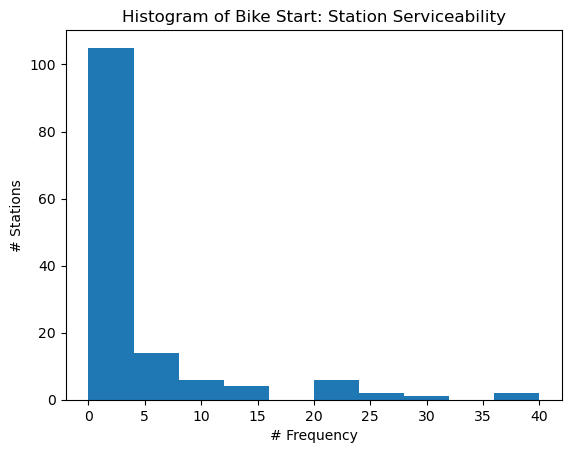

In [13]:
# Serviceability of stations
plt.hist(fdf.tessellation['start_frequency'])
plt.title('Histogram of Bike Start: Station Serviceability')
plt.ylabel('# Stations')
plt.xlabel('# Frequency')
plt.show()


## TO-DO: Time Probability Distribution (Eigenbehavior)
Given monthly data, find the probability of starting the bike during each hours of per day.

We can also reference this to MOD2 eigenbehavior

In [14]:
## TO-DO

# df_csv assign new column for hour block

# Groupby hour block for each day, aggregate size

# Plot histogram distribution

## TO-DO: Combine with census tract
Goal: Map tessellation on census tract tessellation

Each census tract includes several stations. We want to assign census tract number to each station given coordinates. 

Then use census tract tesselllation, and flow df to construct visualization.

[bayareacensus](http://www.bayareacensus.ca.gov/small/small.htm)

[census.gov](https://www2.census.gov/geo/pdfs/maps-data/data/FAQ_for_Census_Bureau_Public_Geocoder.pdf)


trgris package:
[Tigris Package](https://stackoverflow.com/questions/51499410/retrieve-census-tract-from-coordinates)

Shape File:
[census bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Census+Tracts)

# Part II: Data Analysis Plan (5pts)
Which methods studied in class you plan to apply. (note: you have to distribute different measurements for each member of the projects in groups).

1. FLow Data Frame: skMob-FlowDataFrame_Oct19.ipynb
    - O-D pairs of stations
    - O-D pairs of census tract
2. Travel Behavior Analysis (Eigenbehavior)
    - Time distribution of biking
3. Trip Distribution

# Part III: Research Story (5pts)
Select a paper related with the selected dataset describe their findings here. It does not have to be exactly the same data. It is only important that you read and refer here something published about an analysis of the similar kind of network you chose. After you select a data set of your interest, we can help you to find other related articles for you to write about in you mini-project written report.

**Selected Research Paper:**

[Micromobility evolution and expansion](https://escholarship.org/content/qt96g9c9nd/qt96g9c9nd.pdf)

[Enhancing equitable service level](https://www.sciencedirect.com/science/article/abs/pii/S096669232030096X)

![OD distribution](data/rp-img1.png)

The article tracked the uses of bikes(Ford GoBike and JUMP Bike) in San Francisco. The data included origin and destination information of each trip. With that data, they figured out the frequency of use for each location and it is illustrated with images. Like this article, we came up with a figure showing the path by using origin and end location,and found out the frequency of each point. 

a change